# Import libraries

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import Dataset

In [99]:
df_pitches=pd.read_csv("pitches.csv")
df_atbats=pd.read_csv("atbats.csv")

# Data Cleaning and transformation

In [100]:
display(df_pitches.columns)

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

In [43]:
df_pitches["pitch_type"].unique()

array(['FF', 'CU', 'FC', 'SI', 'CH', 'FT', 'IN', 'SL', nan, 'KC', 'EP',
       'FS', 'FO', 'PO', 'KN', 'UN', 'SC', 'FA', 'AB'], dtype=object)

In [44]:
pitch_types_to_remove = ['nan','UN', 'AB', 'EP', 'FA', 'FO', 'IN', 'PO']

# filter out rows with the specified pitch types
df_pitches = df_pitches[~df_pitches['pitch_type'].isin(pitch_types_to_remove)]
# filter out rows with NaN pitch types
df_pitches = df_pitches[pd.notna(df_pitches['pitch_type'])]

df_pitches["pitch_type"].unique()

array(['FF', 'CU', 'FC', 'SI', 'CH', 'FT', 'SL', 'KC', 'FS', 'KN', 'SC'],
      dtype=object)

In [45]:
def transformation(col):
    vals= set()
    for val in col: 
        vals.add(val)
    vals={item: index for index, item in enumerate(vals)}
    col_new=col.map(vals)    
    #print(col_new)
    print(vals)
    return col_new

In [46]:
df_pitches['type']=transformation(df_pitches['type'])
df_pitches=df_pitches.dropna()

{'B': 0, 'S': 1, 'X': 2}


In [47]:
len(df_pitches["ab_id"].unique())

734732

In [49]:
merged_df = pd.merge(df_atbats[['batter_id', 'pitcher_id', 'event', 'ab_id']], df_pitches, on='ab_id')

# Print the first few rows of the merged dataframe
print(merged_df.head())

   batter_id  pitcher_id      event       ab_id     px     pz  start_speed   
0     572761      452657  Groundout  2015000001  0.416  2.963         92.9  \
1     572761      452657  Groundout  2015000001 -0.191  2.347         92.8   
2     572761      452657  Groundout  2015000001 -0.518  3.284         94.1   
3     572761      452657  Groundout  2015000001 -0.641  1.221         91.0   
4     572761      452657  Groundout  2015000001 -1.821  2.083         75.4   

   end_speed  spin_rate  spin_dir  ...  pitch_type  event_num  b_score   
0       84.1   2305.052   159.235  ...          FF          3      0.0  \
1       84.1   2689.935   151.402  ...          FF          4      0.0   
2       85.2   2647.972   145.125  ...          FF          5      0.0   
3       84.0   1289.590   169.751  ...          FF          6      0.0   
4       69.6   1374.569   280.671  ...          CU          7      0.0   

   b_count  s_count  outs  pitch_num  on_1b  on_2b  on_3b  
0      0.0      0.0   0.0 

# Feature Engineering

In [50]:
col_list=["pitcher_id",'px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z','type','pitch_type']

In [51]:
df_features=merged_df[col_list]

In [52]:
df_features

,pitcher_id,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,...,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,type,pitch_type
0,452657,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,...,-3.995000,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,1,FF
1,452657,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,...,-5.980000,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,1,FF
2,452657,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,...,-3.337000,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,1,FF
3,452657,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,...,-6.567000,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,0,FF
4,452657,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,...,0.325000,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,0,CU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838735,623352,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,...,-0.859601,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,2,SL
2838736,623352,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,...,-5.100730,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,0,FF
2838737,623352,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,...,-4.717196,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,1,FF
2838738,623352,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,...,-7.246702,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,1,FF


In [53]:
df_features['pitch_type']=transformation(df_features['pitch_type'])

{'CU': 0, 'FT': 1, 'CH': 2, 'KC': 3, 'KN': 4, 'SC': 5, 'SL': 6, 'FS': 7, 'FF': 8, 'SI': 9, 'FC': 10}


/var/folders/2h/9_s3l0m92f333yjdcwr8869m0000gn/T/ipykernel_75934/284834033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['pitch_type']=transformation(df_features['pitch_type'])


In [54]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Select the columns to be scaled (excluding 'pitcher_id')
scale_cols = [col for col in col_list if col != ['pitcher_id','type','pitch_type']]

df_features_scaled = df_features[col_list].copy()

# Scale the selected columns
df_features_scaled.loc[:, scale_cols] = scaler.fit_transform(df_features.loc[:, scale_cols])

In [55]:
df_features

,pitcher_id,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,...,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,type,pitch_type
0,452657,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,...,-3.995000,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,1,8
1,452657,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,...,-5.980000,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,1,8
2,452657,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,...,-3.337000,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,1,8
3,452657,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,...,-6.567000,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,0,8
4,452657,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,...,0.325000,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838735,623352,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,...,-0.859601,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,2,6
2838736,623352,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,...,-5.100730,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,0,8
2838737,623352,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,...,-4.717196,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,1,8
2838738,623352,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,...,-7.246702,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,1,8


In [56]:
df_features.columns

Index(['pitcher_id', 'px', 'pz', 'start_speed', 'end_speed', 'spin_rate',
       'spin_dir', 'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az',
       'sz_bot', 'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0', 'z0',
       'pfx_x', 'pfx_z', 'type', 'pitch_type'],
      dtype='object')

# Kmeans Elbow Analysis

In [58]:
k = 3  # Choose the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_features)

clusters

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [60]:
# Add cluster labels to the original dataset
df_features['cluster'] = clusters

# Group the pitchers by cluster
grouped_pitchers = df_features.groupby(['pitcher_id', 'cluster']).size().reset_index(name='count')

/var/folders/2h/9_s3l0m92f333yjdcwr8869m0000gn/T/ipykernel_75934/1598216429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['cluster'] = clusters


In [61]:
grouped_pitchers

,pitcher_id,cluster,count
0,112526,2,10035
1,115629,2,553
2,136600,2,118
3,150116,2,618
4,150274,2,129
...,...,...,...
1326,669456,0,1802
1327,670036,0,159
1328,670950,0,2232
1329,672335,0,220


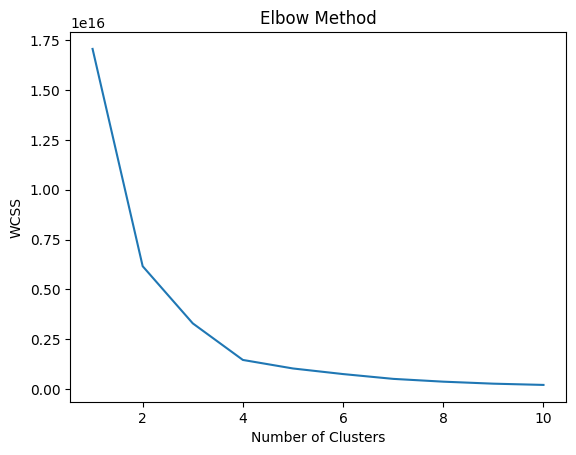

In [62]:
wcss = []
max_clusters = 10  # Maximum number of clusters to test
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_features)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


# Final Kmeans Model

In [63]:
# Run K-means clustering with the optimal number of clusters (4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_features)

# Add cluster labels to df_features
df_features['cluster'] = clusters

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/2h/9_s3l0m92f333yjdcwr8869m0000gn/T/ipykernel_75934/1502962697.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['cluster'] = clusters


In [64]:
df_features

,pitcher_id,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,...,x,x0,y,y0,z0,pfx_x,pfx_z,type,pitch_type,cluster
0,452657,0.416000,2.963000,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,...,101.140000,2.280000,158.780000,50.0,5.302000,4.160000,10.930000,1,8,1
1,452657,-0.191000,2.347000,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,...,124.280000,2.119000,175.410000,50.0,5.307000,6.570000,12.000000,1,8,1
2,452657,-0.518000,3.284000,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,...,136.740000,2.127000,150.110000,50.0,5.313000,7.610000,10.880000,1,8,1
3,452657,-0.641000,1.221000,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,...,109.685636,2.279000,187.463482,50.0,5.210000,1.170000,6.450000,0,8,1
4,452657,-1.821000,2.083000,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,...,146.527525,2.179000,177.242829,50.0,5.557000,-8.430000,-1.650000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838735,623352,0.230280,1.784910,83.9,78.2,608.594,275.800,10.5,8.8,23.9,...,108.220000,3.502933,190.580000,50.0,4.912177,-3.319733,-0.337153,2,6,0
2838736,623352,-1.211049,2.479020,97.7,89.5,2262.907,155.009,-26.9,2.9,23.8,...,163.160000,2.792346,171.850000,50.0,5.061932,4.547344,9.755265,0,8,0
2838737,623352,-0.444578,2.619287,97.3,89.6,2514.010,147.166,-40.5,3.3,23.8,...,133.950000,3.026107,168.060000,50.0,5.040691,6.511325,10.090051,1,8,0
2838738,623352,-0.259813,1.336484,95.9,88.6,2318.775,144.921,-34.2,3.8,23.8,...,126.910000,3.041058,202.740000,50.0,4.881930,6.460353,9.199100,1,8,0


In [65]:
unique_pitcher_clusters = df_features[['pitcher_id', 'cluster']].drop_duplicates(subset='pitcher_id', keep='first')


In [66]:
unique_pitcher_clusters

,pitcher_id,cluster
0,452657,1
19,425794,1
154,457435,1
179,435400,1
211,519166,3
...,...,...
2772558,623364,0
2774305,664180,0
2790345,656954,0
2817718,607644,0


# Merging cluster and pitcher infomration with AtBats dataset

In [67]:
merged_df = unique_pitcher_clusters.merge(df_atbats, on='pitcher_id')

In [68]:
result_df = merged_df[['batter_id',"pitcher_id",'cluster', 'event',]]

In [69]:
result_df

,batter_id,pitcher_id,cluster,event
0,572761,452657,1,Groundout
1,518792,452657,1,Double
2,407812,452657,1,Single
3,425509,452657,1,Strikeout
4,571431,452657,1,Strikeout
...,...,...,...,...
740376,596119,607054,0,Single
740377,506702,607054,0,Double
740378,624407,607054,0,Double
740379,643217,607054,0,Single


In [70]:
# Find the number of unique batter_id and pitcher_id pairs
unique_pairs_count = result_df[['batter_id', 'pitcher_id']].drop_duplicates().shape[0]

print(f"Number of unique batter_id and pitcher_id pairs: {unique_pairs_count}")


Number of unique batter_id and pitcher_id pairs: 232540


In [71]:
result_df["event"].unique()

array(['Groundout', 'Double', 'Single', 'Strikeout', 'Walk', 'Runner Out',
       'Forceout', 'Pop Out', 'Lineout', 'Triple', 'Flyout', 'Home Run',
       'Sac Fly', 'Hit By Pitch', 'Sac Bunt', 'Field Error',
       'Grounded Into DP', 'Bunt Pop Out', 'Bunt Lineout',
       'Strikeout - DP', 'Fielders Choice Out', 'Bunt Groundout',
       'Catcher Interference', 'Double Play', 'Intent Walk',
       'Fielders Choice', 'Sac Fly DP', 'Batter Interference',
       'Triple Play', 'Sacrifice Bunt DP'], dtype=object)

### Positive outcomes for the pitcher

In [84]:
def event_to_outcome(event):
    positive_events = ['Groundout', 'Strikeout', 'Runner Out', 'Forceout', 'Pop Out', 'Lineout',
                       'Flyout', 'Sac Fly', 'Sac Bunt', 'Grounded Into DP', 'Bunt Pop Out',
                       'Bunt Lineout', 'Strikeout - DP', 'Fielders Choice Out', 'Bunt Groundout',
                       'Double Play', 'Sac Fly DP', 'Batter Interference', 'Triple Play',
                       'Sacrifice Bunt DP']
    negative_events = ['Double', 'Single', 'Walk', 'Hit By Pitch', 'Field Error', 'Intent Walk',
                       'Fielders Choice', 'Catcher Interference']
    if event in positive_events:
        return 'Positive'
    elif event in negative_events:
        return 'Negative'

# Apply the custom function to the 'event' column and create a new 'outcome' column
result_df['outcome'] = result_df['event'].apply(event_to_outcome)

# Show the resulting DataFrame
print(result_df)

        batter_id  pitcher_id  cluster      event   outcome
0          572761      452657        1  Groundout  Positive
1          518792      452657        1     Double  Negative
2          407812      452657        1     Single  Negative
3          425509      452657        1  Strikeout  Positive
4          571431      452657        1  Strikeout  Positive
...           ...         ...      ...        ...       ...
740376     596119      607054        0     Single  Negative
740377     506702      607054        0     Double  Negative
740378     624407      607054        0     Double  Negative
740379     643217      607054        0     Single  Negative
740380     543877      607054        0  Strikeout  Positive

[740381 rows x 5 columns]


/var/folders/2h/9_s3l0m92f333yjdcwr8869m0000gn/T/ipykernel_75934/2258587940.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['outcome'] = result_df['event'].apply(event_to_outcome)


In [86]:
result_df = result_df.dropna(subset=['outcome'])

result_df["outcome"].unique()

array(['Positive', 'Negative'], dtype=object)

In [87]:
result_df["outcome"]=transformation(result_df["outcome"])

{'Negative': 0, 'Positive': 1}


/var/folders/2h/9_s3l0m92f333yjdcwr8869m0000gn/T/ipykernel_75934/2196014130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["outcome"]=transformation(result_df["outcome"])


### Decision tree classifier to pick the pitchers which would have a positive outcome when playing against a particular batter

In [102]:
# Import the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Prepare input and output data
X = result_df[['batter_id', 'cluster']]
y = result_df['outcome']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the outcomes for the test set
y_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.00      0.01     64928
           1       0.70      1.00      0.82    149488

    accuracy                           0.70    214416
   macro avg       0.49      0.50      0.41    214416
weighted avg       0.57      0.70      0.57    214416



In [103]:
def recommend_pitchers_with_confidence(batter_id, clf, clusters, result_df, df_names):
    # Predict the outcome probabilities for each pitcher cluster against the given batter_id
    cluster_outcome_probabilities = clf.predict_proba([[batter_id, cluster] for cluster in clusters])

    # Find the clusters with the most positive predicted outcome (Positive: 0)
    positive_outcome_probabilities = [prob[0] for prob in cluster_outcome_probabilities]
    max_positive_probability = max(positive_outcome_probabilities)
    positive_clusters = [cluster for cluster, prob in zip(clusters, positive_outcome_probabilities) if prob == max_positive_probability]

    # Get the pitchers in the clusters with the most positive predicted outcome
    recommended_pitchers = result_df[result_df['cluster'].isin(positive_clusters)]['pitcher_id'].unique()

    # Merge recommended_pitchers with df_names to get the names of the recommended pitchers
    recommended_pitcher_names = df_names[df_names['id'].isin(recommended_pitchers)]

    return recommended_pitcher_names, max_positive_probability

# Example usage:
batter_id = 518792  # Replace this with the batter_id you want to query
clusters = [0, 1, 2, 3]  # Replace these with the cluster labels in your dataset

# Assuming your df_names DataFrame looks like this

recommended_pitcher_names, confidence = recommend_pitchers_with_confidence(batter_id, clf, clusters, result_df, df_names)

print(f"Recommended pitchers to play against batter {batter_id}" )
print(recommended_pitcher_names)



Recommended pitchers to play against batter 518792
         id first_name  last_name
24   276351      Jason     Grilli
68   150274        Joe     Nathan
70   112526    Bartolo      Colon
77   234194      Buddy    Carlyle
80   276514      Kevin      Gregg
147  115629     LaTroy    Hawkins
154  276542    Joaquin     Benoit
158  285064       Ryan  Vogelsong
243  279571       Matt    Belisle
250  285079       R.A.     Dickey
280  150359       A.J.    Burnett
282  218596        Tim     Hudson
287  282332         CC   Sabathia
322  150302      Jason    Marquis
329  279824       Mark    Buehrle
351  329092      Randy     Choate
484  136600      Bruce       Chen
681  150116      Randy       Wolf
728  217096      Barry       Zito
967  276520    Bronson     Arroyo


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
